Провести обучение нейронной сети на наборе данных notMNIST_small

In [1]:
import os
import random

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, CategoryEncoding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.optimizers import Adam

DATA_FOLDER = 'notMNIST_small'
RANDOM_STATE = 42

В первую очередь загрузим изображения датасета

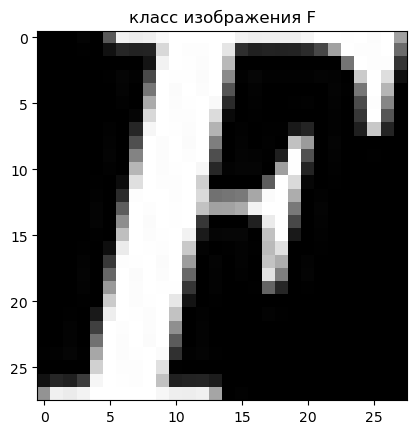

In [2]:
#указываем путь к каталогу с изображениями
path = r"C:\Users\User\notMNIST_small"
dirs = os.listdir(path)

#массив изображений
X = []
#массив целевых меток
y = []

for folder_name in dirs:
    for file_name in os.listdir(path + '\\' + folder_name):
        try:
            img = Image.open(path + '\\' + folder_name +'\\' + file_name)
            y.append(folder_name)
            X.append(np.asarray(img, dtype=np.float32))
        except:
            continue

X = np.asarray(X)

#выведем случайное изображение
random_id = random.randint(0, X.shape[0])
plt.imshow(X[random_id], cmap='gray')
plt.title(f'класс изображения {y[random_id]}');

Преобразуем целевые метки в разряженный массив

In [3]:
encoding = CategoryEncoding(num_tokens=10, output_mode="one_hot")
y_enc = encoding(LabelEncoder().fit_transform(y)).numpy()

Загрузив изображения, перемешаем их случайным образом, чтобы тестовую и обучающую выборку попали с одинаковой вероятностью изображения каждого их классов

In [4]:
# Выполним нормализацию значений
X = X / 255.0

# Перемешаем случайным образом исходные массивы изображений и меток
index = np.arange(X.shape[0])

np.random.seed(RANDOM_STATE)
np.random.shuffle(index)
X, y_enc = X[index], y_enc[index]

In [5]:
print(len(y_enc))
X.shape

18724


(18724, 28, 28)

Перемешав изображения разобьем на датасет на тренировочную и тестовую выборку

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, random_state = RANDOM_STATE, train_size=0.7)

In [7]:
print(X_train.shape)
len(y_train)

(13106, 28, 28)


13106

Построим сверточную нейронную сеть

In [8]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=32, kernel_size=3, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128,kernel_size=1),
    DefaultConv2D(filters=128,kernel_size=1),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [9]:
model.summary()  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         8

In [10]:
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [11]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_categorical_accuracy',
        min_delta=1e-3,
        patience=5,
        verbose=1
    ),]

In [12]:
history = model.fit(X_train, y_train, batch_size=256, epochs=50,
                        callbacks=callbacks, 
                        validation_split=0.2, 
                        #class_weight = class_weights,
                        verbose=1)

Epoch 1/50
41/41 [==============================] - 8s 171ms/step - loss: 1.8467 - accuracy: 0.3254 - val_loss: 0.7978 - val_accuracy: 0.7879
Epoch 2/50
41/41 [==============================] - 7s 174ms/step - loss: 0.9638 - accuracy: 0.6898 - val_loss: 0.4884 - val_accuracy: 0.8692
Epoch 3/50
41/41 [==============================] - 7s 167ms/step - loss: 0.6956 - accuracy: 0.7882 - val_loss: 0.3855 - val_accuracy: 0.8917
Epoch 4/50
41/41 [==============================] - 7s 170ms/step - loss: 0.5754 - accuracy: 0.8243 - val_loss: 0.3342 - val_accuracy: 0.9047
Epoch 5/50
41/41 [==============================] - 7s 169ms/step - loss: 0.4942 - accuracy: 0.8488 - val_loss: 0.3234 - val_accuracy: 0.9062
Epoch 6/50
41/41 [==============================] - 7s 165ms/step - loss: 0.4449 - accuracy: 0.8665 - val_loss: 0.2976 - val_accuracy: 0.9092
Epoch 7/50
41/41 [==============================] - 7s 167ms/step - loss: 0.4006 - accuracy: 0.8740 - val_loss: 0.2768 - val_accuracy: 0.9157
Epoch 

Epoch 22/50
41/41 [==============================] - 7s 169ms/step - loss: 0.2256 - accuracy: 0.9264 - val_loss: 0.2255 - val_accuracy: 0.9382
Epoch 23/50
41/41 [==============================] - 7s 162ms/step - loss: 0.2120 - accuracy: 0.9292 - val_loss: 0.2377 - val_accuracy: 0.9329
Epoch 24/50
41/41 [==============================] - 7s 166ms/step - loss: 0.2119 - accuracy: 0.9310 - val_loss: 0.2427 - val_accuracy: 0.9363
Epoch 25/50
41/41 [==============================] - 7s 168ms/step - loss: 0.1986 - accuracy: 0.9351 - val_loss: 0.2387 - val_accuracy: 0.9367
Epoch 26/50
41/41 [==============================] - 7s 167ms/step - loss: 0.1967 - accuracy: 0.9337 - val_loss: 0.2348 - val_accuracy: 0.9340
Epoch 27/50
41/41 [==============================] - 7s 171ms/step - loss: 0.1898 - accuracy: 0.9368 - val_loss: 0.2454 - val_accuracy: 0.9405
Epoch 28/50
41/41 [==============================] - 7s 166ms/step - loss: 0.1865 - accuracy: 0.9367 - val_loss: 0.2504 - val_accuracy: 0.9344

Epoch 43/50
41/41 [==============================] - 7s 170ms/step - loss: 0.1328 - accuracy: 0.9521 - val_loss: 0.2500 - val_accuracy: 0.9413
Epoch 44/50
41/41 [==============================] - 7s 164ms/step - loss: 0.1305 - accuracy: 0.9541 - val_loss: 0.2677 - val_accuracy: 0.9439
Epoch 45/50
41/41 [==============================] - 7s 169ms/step - loss: 0.1261 - accuracy: 0.9565 - val_loss: 0.2859 - val_accuracy: 0.9409
Epoch 46/50
41/41 [==============================] - 7s 161ms/step - loss: 0.1275 - accuracy: 0.9535 - val_loss: 0.2550 - val_accuracy: 0.9428
Epoch 47/50
41/41 [==============================] - 7s 168ms/step - loss: 0.1298 - accuracy: 0.9548 - val_loss: 0.2577 - val_accuracy: 0.9394
Epoch 48/50
41/41 [==============================] - 7s 162ms/step - loss: 0.1262 - accuracy: 0.9576 - val_loss: 0.2872 - val_accuracy: 0.9367
Epoch 49/50
41/41 [==============================] - 7s 174ms/step - loss: 0.1335 - accuracy: 0.9544 - val_loss: 0.2467 - val_accuracy: 0.9416

In [13]:
scores = model.evaluate(X_test, y_test, verbose=0)

print("Accuracy на тестовых данных: %.2f%%" % (scores[1]*100))

Accuracy на тестовых данных: 94.45%


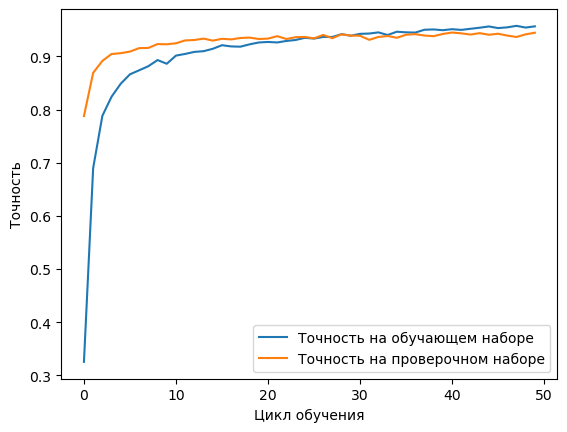

In [14]:
plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
plt.plot(
    history.history['val_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Цикл обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()
pass;

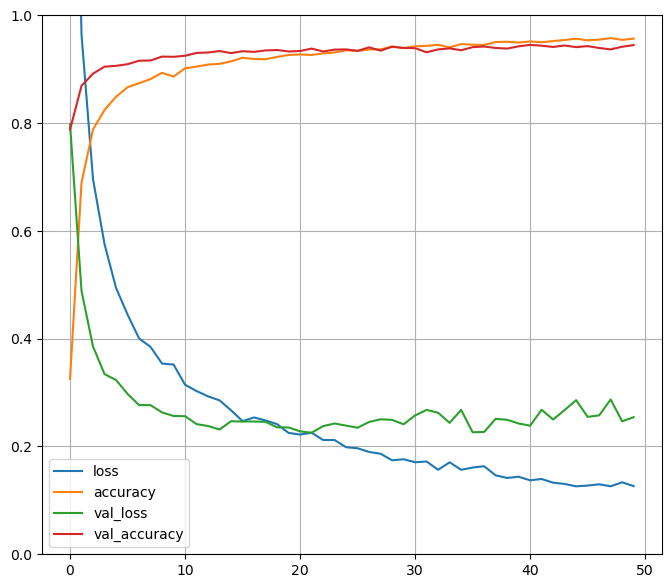

In [15]:
pd.DataFrame(history.history).plot(figsize=(8, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()